In [20]:
import numpy as np
import tensorflow as tf
from keras import layers, regularizers
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import pathlib
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import json

data_dir = pathlib.Path("flower_photos")

img_height = 180
img_width = 180
batch_size = 32
num_classes = 5

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
class_names


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

class MacroF1(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.f1_scores = []
    
    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []
        
        for x, y in self.validation_data:
            logits = self.model.predict(x, verbose=0)
            preds = tf.argmax(logits, axis=1).numpy()
            y_pred.extend(preds)
            y_true.extend(y.numpy())
        
        macro_f1 = f1_score(y_true, y_pred, average="macro")
        self.f1_scores.append(macro_f1)
        logs["val_macro_f1"] = macro_f1
        print(f" — val_macro_f1: {macro_f1:.4f}")


In [22]:
class EpochTimer(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_times = []
        self.epoch_start_time = None
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f" — epoch_time: {epoch_time:.2f}s (avg: {np.mean(self.epoch_times):.2f}s)")


In [23]:
def build_model(
    conv_layers=2,
    dense_layers=1,
    dense_units=128,
    activation="relu",
    learning_rate=0.001,
    regularizer=None,
    reg_value=0.001,
    use_pooling=True,
    use_batchnorm=False,
    use_augmentation=True
):
    # Regularizer selection
    if regularizer == "l1":
        reg = regularizers.l1(reg_value)
    elif regularizer == "l2":
        reg = regularizers.l2(reg_value)
    else:
        reg = None
    
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(img_height, img_width, 3)))

    # Augmentation
    if use_augmentation:
        model.add(data_augmentation)

    # Rescaling
    model.add(layers.Rescaling(1. / 255))

    # --- Convolutional Blocks (Option B when pooling enabled) ---
    for i in range(conv_layers):
        filters = 32 * (2**i)

        # 1st Conv
        model.add(layers.Conv2D(filters, 3, padding="same", kernel_regularizer=reg))
        if use_batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))

        # 2nd Conv
        model.add(layers.Conv2D(filters, 3, padding="same", kernel_regularizer=reg))
        if use_batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))

        # Pool once per block (optional)
        if use_pooling:
            model.add(layers.MaxPooling2D())

    # --- Global Average Pooling ---
    model.add(layers.GlobalAveragePooling2D())

    # Dense layers
    for _ in range(dense_layers):
        model.add(layers.Dense(dense_units, activation=activation, kernel_regularizer=reg))
        if use_batchnorm:
            model.add(layers.BatchNormalization())

    # Output logits
    model.add(layers.Dense(num_classes))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model


In [24]:
def plot_training_history(history, f1_callback):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # Macro F1
    axes[2].plot(f1_callback.f1_scores, label='Val Macro F1', color='green')
    axes[2].set_title('Macro F1 Score')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Macro F1')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    plt.close()


In [25]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    plt.close()


In [26]:
def evaluate_model(model, val_ds):
    y_true = []
    y_pred = []
    
    for x, y in val_ds:
        logits = model.predict(x, verbose=0)
        preds = tf.argmax(logits, axis=1).numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())
    
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    
    return y_true, y_pred, macro_f1

def print_model_weights_info(model):
    print("MODEL ARCHITECTURE & WEIGHTS INFO")
    
    for i, layer in enumerate(model.layers):
        weights = layer.get_weights()
        if len(weights) > 0:
            print(f"\nLayer {i}: {layer.name} ({layer.__class__.__name__})")
            for j, w in enumerate(weights):
                weight_type = "Kernel" if j == 0 else "Bias" if j == 1 else f"Param_{j}"
                print(f"  {weight_type}: shape={w.shape}, "
                      f"mean={w.mean():.6f}, std={w.std():.6f}, "
                      f"min={w.min():.6f}, max={w.max():.6f}")


In [27]:
grid_search_configs = [
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0.001},
    
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0.0005},
    
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0.0003},
    
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0.0001},
    
    
    
    # {"conv_layers": 1, "dense_layers": 1, "dense_units": 64, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": False, 
    #  "regularizer": None, "reg_value": 0.001},
    
    # {"conv_layers": 2, "dense_layers": 1, "dense_units": 64, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": False, 
    #  "regularizer": None, "reg_value": 0.001},
    
    # {"conv_layers": 4, "dense_layers": 1, "dense_units": 64, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": False, 
    #  "regularizer": None, "reg_value": 0.001},
    
    # {"conv_layers": 1, "dense_layers": 2, "dense_units": 64, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": False, 
    #  "regularizer": None, "reg_value": 0.001},
    
    # {"conv_layers": 2, "dense_layers": 2, "dense_units": 64, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": False, 
    #  "regularizer": None, "reg_value": 0.001},
    
    # {"conv_layers": 4, "dense_layers": 2, "dense_units": 64, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": False, 
    #  "regularizer": None, "reg_value": 0.001},
    
    #   {"conv_layers": 1, "dense_layers": 1, "dense_units": 128, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": False, 
    #  "regularizer": None, "reg_value": 0.001},
    
    # {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": False, 
    #  "regularizer": None, "reg_value": 0.001},
    
    # {"conv_layers": 4, "dense_layers": 1, "dense_units": 128, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": False, 
    #  "regularizer": None, "reg_value": 0.001},
    
    # {"conv_layers": 1, "dense_layers": 2, "dense_units": 128, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": False, 
    #  "regularizer": None, "reg_value": 0.001},
    
    # {"conv_layers": 2, "dense_layers": 2, "dense_units": 128, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": False, 
    #  "regularizer": None, "reg_value": 0.001},
    
    # {"conv_layers": 4, "dense_layers": 2, "dense_units": 128, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": False, 
    #  "regularizer": None, "reg_value": 0.001},
    
]

# Run experiments
results = []
best_f1 = 0
best_model = None
best_config = None
best_history = None
best_f1_callback = None



EXPERIMENT 1/4
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0.001}


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.4695 - loss: 1.3162 — val_macro_f1: 0.0841
 — epoch_time: 99.85s (avg: 99.85s)
92/92 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5136 - loss: 1.2050 - val_accuracy: 0.2425 - val_loss: 1.6112 - val_macro_f1: 0.0841
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.5897 - loss: 1.0005 — val_macro_f1: 0.1129
 — epoch_time: 92.42s (avg: 96.13s)
92/92 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5875 - loss: 1.0295 - val_accuracy: 0.2561 - val_loss: 1.5989 - val_macro_f1: 0.1129
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.6353 - loss: 0.9452 — val_macro_f1: 0.1966
 — epoch_time: 93.20s (avg: 95.16s)
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6219 - loss: 0.9643 - val_accuracy: 0.3120 - val_loss: 1.4747 - val_macro_f1: 0.1966
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.6351 - loss: 0.9068 — val_macro_f1: 0.2702
 — epoch_time: 91.60s (avg: 94.27s)
92/92

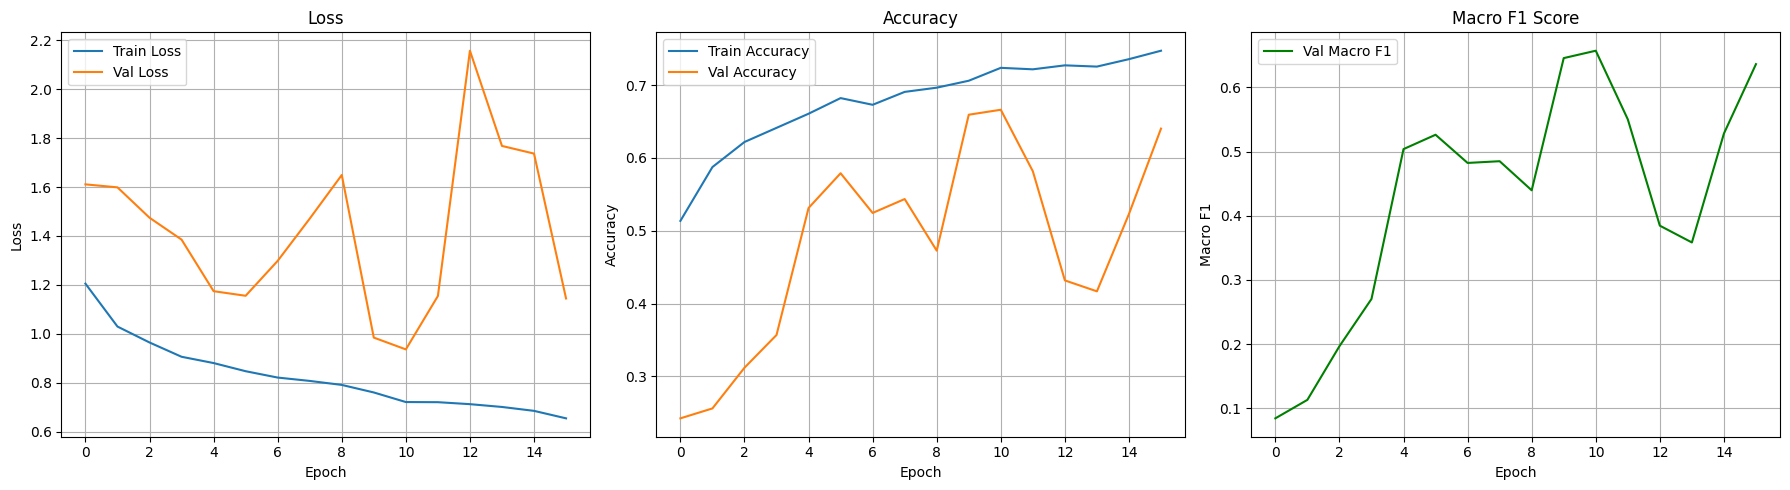

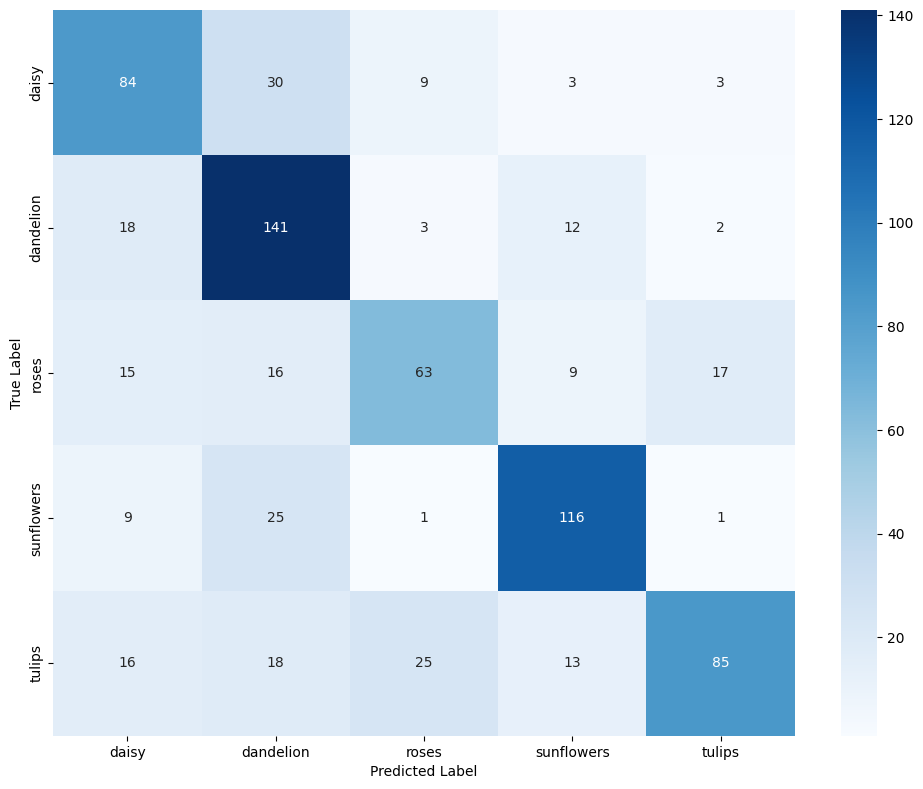


Results: Macro F1 = 0.6574, Time = 1485.93s


EXPERIMENT 2/4
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0.0005}
Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.4557 - loss: 1.3576 — val_macro_f1: 0.0867
 — epoch_time: 100.47s (avg: 100.47s)
92/92 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5184 - loss: 1.2014 - val_accuracy: 0.2439 - val_loss: 1.6534 - val_macro_f1: 0.0867
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.5735 - loss: 1.0571 — val_macro_f1: 0.1560
 — epoch_time: 92.86s (avg: 96.67s)
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.5862 - loss: 1.0444 - val_accuracy: 0.2888 - val_loss: 1.6123 - val_macro_f1: 0.1560
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.5945 - loss: 0.9786 — val_macro_f1: 0.1646
 — epoch_time: 92.73s (avg: 95.35s)
92/92 ━━━━━━━━━━━━━━━━━━━━

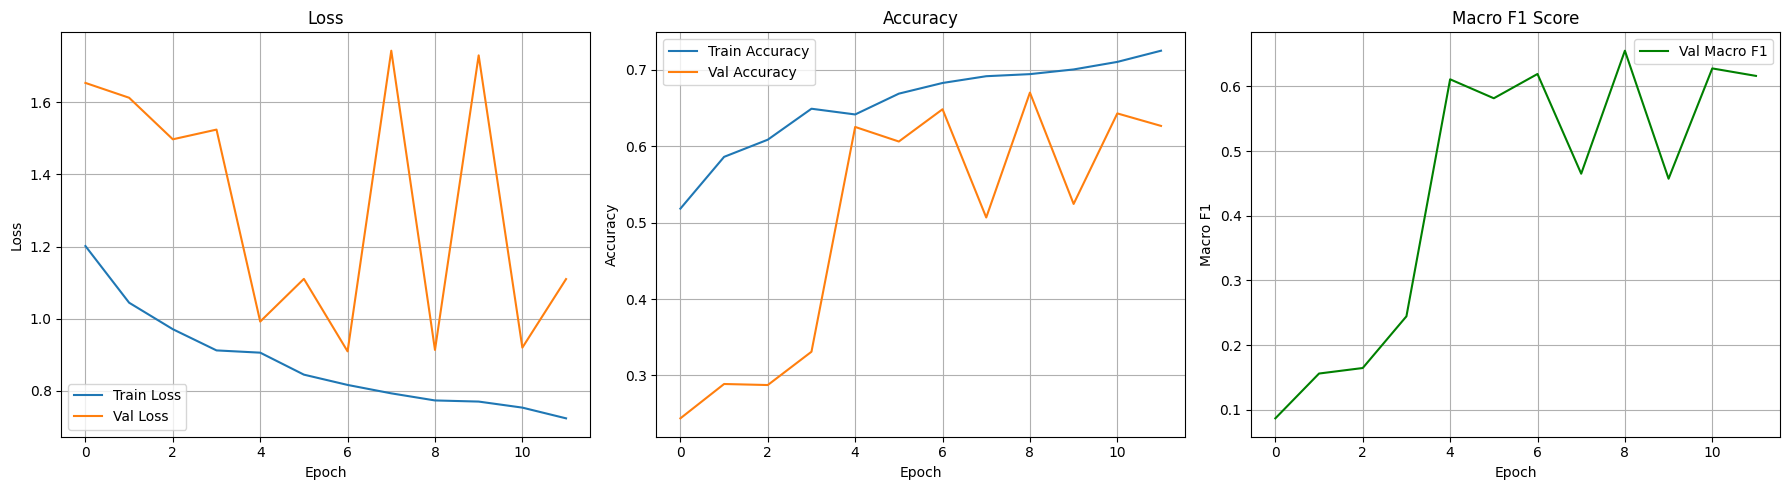

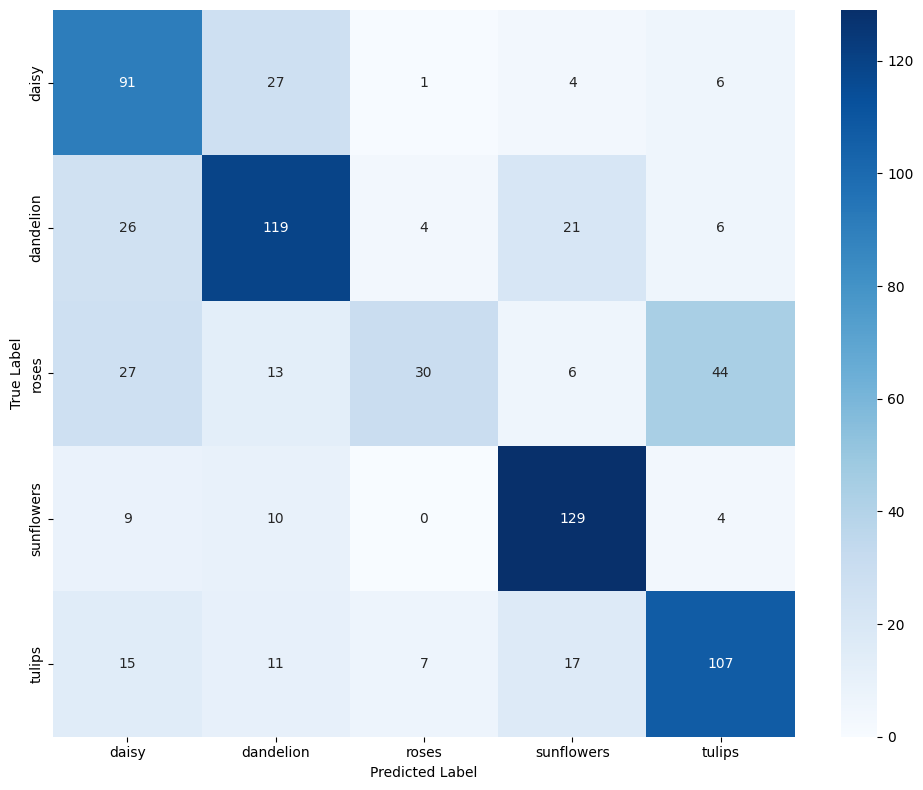


Results: Macro F1 = 0.6193, Time = 1124.06s


EXPERIMENT 3/4
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0.0003}
Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.4711 - loss: 1.3291 — val_macro_f1: 0.0774
 — epoch_time: 99.70s (avg: 99.70s)
92/92 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5150 - loss: 1.2003 - val_accuracy: 0.2398 - val_loss: 1.6114 - val_macro_f1: 0.0774
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.5953 - loss: 1.0469 — val_macro_f1: 0.0774
 — epoch_time: 92.89s (avg: 96.29s)
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6052 - loss: 1.0214 - val_accuracy: 0.2398 - val_loss: 1.6524 - val_macro_f1: 0.0774
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.6077 - loss: 0.9761 — val_macro_f1: 0.1928
 — epoch_time: 92.89s (avg: 95.16s)
92/92 ━━━━━━━━━━━━━━━━━━━━ 9

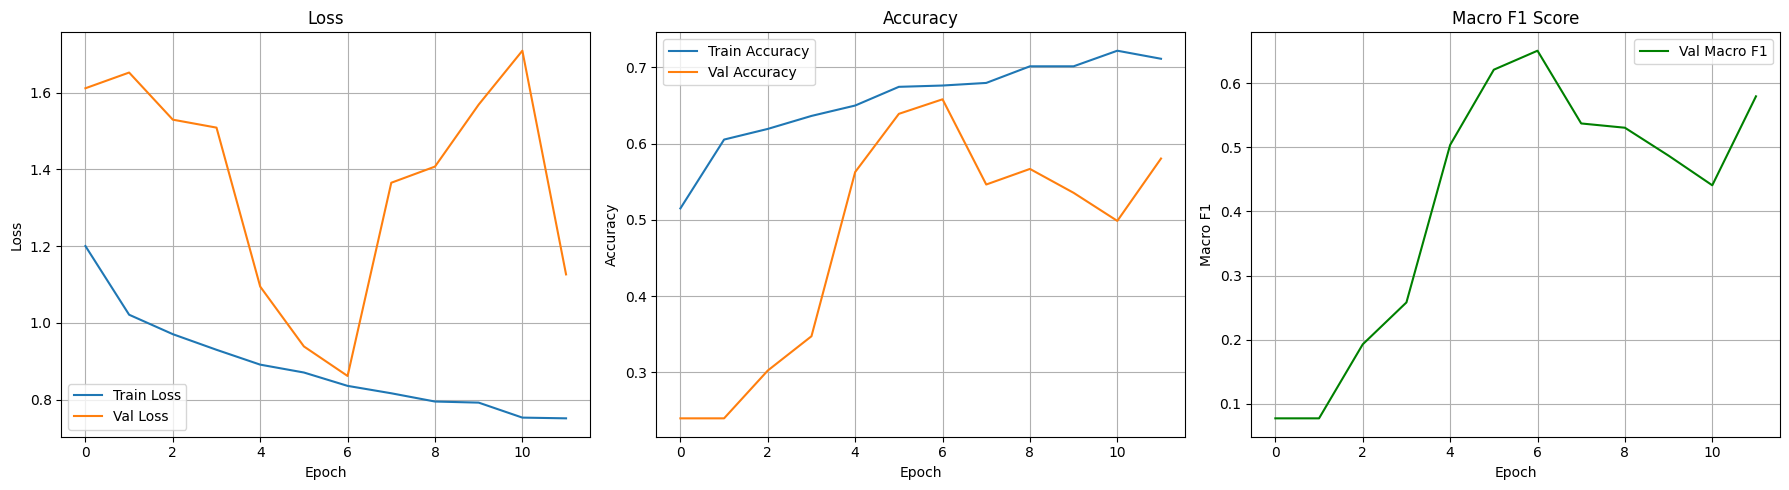

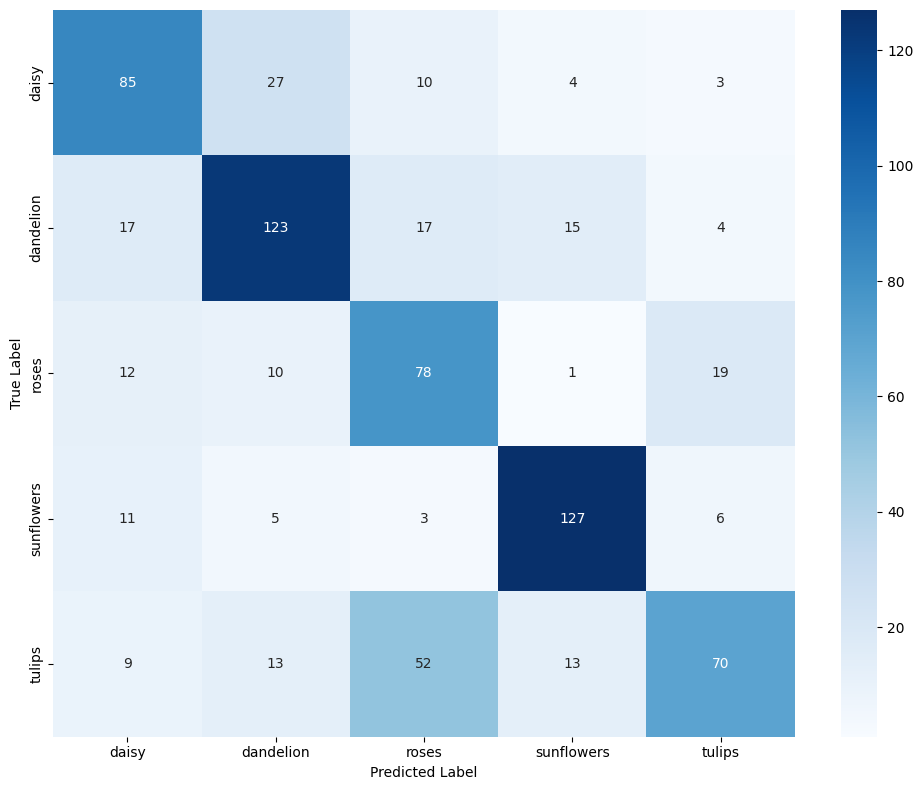


Results: Macro F1 = 0.6506, Time = 1124.36s


EXPERIMENT 4/4
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0.0001}
Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.4415 - loss: 1.4027 — val_macro_f1: 0.0774
 — epoch_time: 97.97s (avg: 97.97s)
92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5112 - loss: 1.2343 - val_accuracy: 0.2398 - val_loss: 1.5950 - val_macro_f1: 0.0774
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.5844 - loss: 1.0514 — val_macro_f1: 0.0774
 — epoch_time: 91.37s (avg: 94.67s)
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 994ms/step - accuracy: 0.5967 - loss: 1.0314 - val_accuracy: 0.2398 - val_loss: 1.5879 - val_macro_f1: 0.0774
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.6007 - loss: 0.9794 — val_macro_f1: 0.1195
 — epoch_time: 91.69s (avg: 93.68s)
92/92 ━━━━━━━━━━━━━━━━━━━━

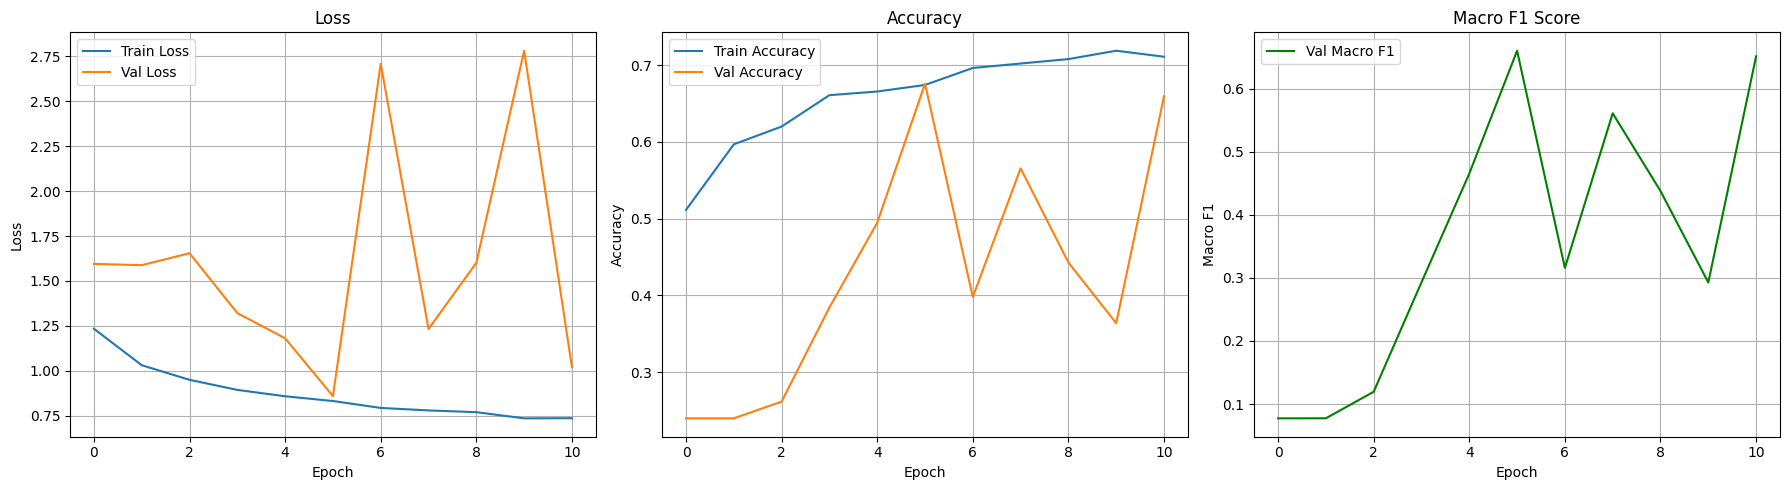

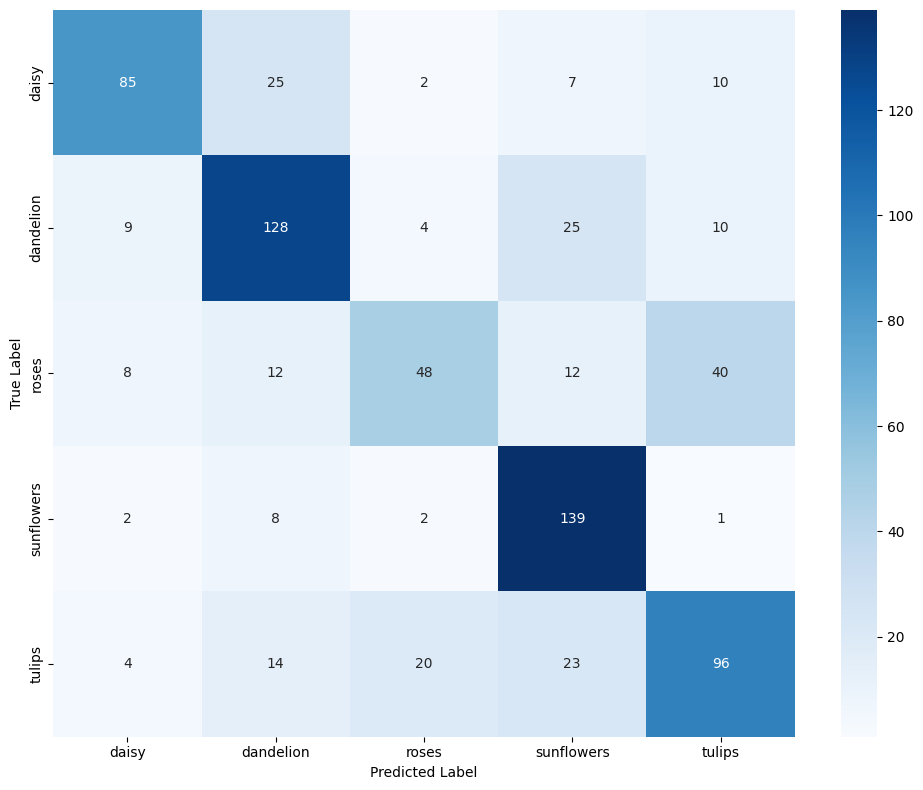


Results: Macro F1 = 0.6601, Time = 1013.05s


In [28]:
epochs = 30

for idx, config in enumerate(grid_search_configs):
    print(f"\n\nEXPERIMENT {idx + 1}/{len(grid_search_configs)}")
    print(f"Config: {config}")
    
    experiment_name = f"exp_{idx+1}"
    
    # Build model
    model = build_model(**config)
    
    # Callbacks
    f1_callback = MacroF1(val_ds)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    epoch_timer = EpochTimer()
    
    # Train
    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[f1_callback, early_stopping, epoch_timer],
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Evaluate
    y_true, y_pred, final_f1 = evaluate_model(model, val_ds)
    
    # Save results
    result = {
        "experiment": idx + 1,
        "config": config,
        "final_macro_f1": final_f1,
        "training_time_seconds": training_time,
        "epochs_trained": len(history.history['loss']),
        "final_val_loss": history.history['val_loss'][-1],
        "final_val_accuracy": history.history['val_accuracy'][-1]
    }
    results.append(result)
    
    # Plot
    plot_training_history(history, f1_callback)
    plot_confusion_matrix(y_true, y_pred, class_names)
    
    # Track best model
    if final_f1 > best_f1:
        best_f1 = final_f1
        best_model = model
        best_config = config
        best_history = history
        best_f1_callback = f1_callback
    
    print(f"\nResults: Macro F1 = {final_f1:.4f}, Time = {training_time:.2f}s")


In [29]:
results_df = pd.DataFrame(results)

print(results_df.to_string(index=False))

print(f"Best Macro F1: {best_f1:.4f}")
print(f"Config: {best_config}")

 experiment                                                                                                                                                                                        config  final_macro_f1  training_time_seconds  epochs_trained  final_val_loss  final_val_accuracy
          1  {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0.001}        0.657362            1485.927493              16        1.144369            0.640327
          2 {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0.0005}        0.619279            1124.062256              12        1.109863            0.626703
          3 {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_

In [30]:
print_model_weights_info(best_model)


y_true, y_pred, _ = evaluate_model(best_model, val_ds)

print(classification_report(y_true, y_pred, target_names=class_names))


MODEL ARCHITECTURE & WEIGHTS INFO

Layer 2: conv2d_26 (Conv2D)
  Kernel: shape=(3, 3, 3, 32), mean=0.000811, std=0.082674, min=-0.161216, max=0.160690
  Bias: shape=(32,), mean=-0.004034, std=0.017581, min=-0.036230, max=0.039311

Layer 3: batch_normalization_20 (BatchNormalization)
  Kernel: shape=(32,), mean=1.001066, std=0.025279, min=0.963506, max=1.084979
  Bias: shape=(32,), mean=-0.015532, std=0.013608, min=-0.053213, max=0.010585
  Param_2: shape=(32,), mean=0.010549, std=0.129040, min=-0.291124, max=0.256191
  Param_3: shape=(32,), mean=0.015662, std=0.012831, min=0.004616, max=0.058157

Layer 5: conv2d_27 (Conv2D)
  Kernel: shape=(3, 3, 32, 32), mean=0.001204, std=0.061920, min=-0.149471, max=0.172560
  Bias: shape=(32,), mean=0.004860, std=0.022011, min=-0.050136, max=0.049144

Layer 6: batch_normalization_21 (BatchNormalization)
  Kernel: shape=(32,), mean=0.999624, std=0.018593, min=0.965887, max=1.042011
  Bias: shape=(32,), mean=-0.025385, std=0.021634, min=-0.093623, ma